In [1]:
# %load science.py
"""
Default imports for pretty much every scientific thing I do.

"""
from __future__ import division
from __future__ import print_function

import os
import random
import math
from collections import namedtuple
from collections import OrderedDict
from pprint import pprint

import numpy as np
from numpy.linalg import inv
import scipy as sp
from scipy import stats
import pandas as pd

# import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


arr = np.array


def mdot(*args):
    """Multi argument dot function.

    http://wiki.scipy.org/Cookbook/MultiDot

    >>> mdot(a, b, c, d)
    """
    return reduce(np.dot, args)


# ipython notebook magic
# %load_ext autoreload
# %autoreload 2
# %matplotlib notebook
%matplotlib inline


# Framework for Bayesian Statistics

The framework is inspired by Allen Downey's [ThinkBayes](http://greenteapress.com/thinkbayes/) which is a fun read and available online.

I learn best by implementing it myself (and I don't particularly like his coding conventions ;)).

In [2]:
class Pmf(OrderedDict):
    """
    A Pmf is an ordered dict which maps from an event, (i.e. an element in the domain) to a probabitly.
    
    Note this implementation does not guarante that the Pmf is normalized
    """
    def normalize(self):
        total = sum(self.values())
        for hyp, value in self.iteritems():
            self[hyp] = self[hyp] / total
        return total
    
    def print(self):
        for k, v in self.iteritems():
            print('{}: {}'.format(k, v))
            
    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        x = range(len(self))
        ax.plot(x, self.values())
    
    def plot_bar(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        x = range(len(self))
        ax.bar(x, self.values())
        
    @property
    def n(self):
        return len(self)
    
    def mean(self):
        return sum(k * v
                   for k, v in self.iteritems())
    
    def var(self):
        mu = self.mean()
        return sum(prob * (x - mu)**2
                   for x, prob in self.iteritems())
        


# Example
pmf = Pmf(zip(['bowl 1', 'bowl 2'],
              [.6, .6]))
print(pmf)
pmf.normalize()
print(pmf)

pmf['bowl 1'] *= .75
pmf['bowl 2'] *= .5
print(pmf)
pmf.normalize()
print(pmf)

Pmf([('bowl 1', 0.6), ('bowl 2', 0.6)])
Pmf([('bowl 1', 0.5), ('bowl 2', 0.5)])
Pmf([('bowl 1', 0.375), ('bowl 2', 0.25)])
Pmf([('bowl 1', 0.6), ('bowl 2', 0.4)])


To do Bayesian statistics we have to be able to update our belief using Bayes rule. See the update function.

Note that you have to implement the likelihood function

In [3]:
class Suite(Pmf):
    """
    A collection of hypotheses which we can updated using bayes rule.
    
    Suite is initialized uniformly.
    """
    def __init__(self, hypos):
        super(Pmf, self).__init__()
        for hypo in hypos:
            self[hypo] = 1
        self.normalize()
        
    def update(self, evidence):
        """Bayes' update"""
        for hypo in self:
            self[hypo] *= self.likelihood(evidence, hypo)
        self.normalize()
        
    def likelihood(self, evidence, hypo):
        """Overwrite me in the child class."""
        raise NotImplementedError()

# Dice
Simple example of how the Suite works.

There are three dice: a 4-sided one, a 6-sided one, and a 12-sided one. Someone randomly picks one of these die (-> uniform prior), rolls it and tells you the result of the roll. Based on this information you're to estimate which of the dice was picked (update your belief).

So let's implement this problem using the Suite. We create a XSidedDice class and implement the likelihood function:

In [4]:
class XSidedDice(Suite):
    """A suite of different x-sided die."""    
    def likelihood(self, roll, sides):
        # the likelihood that the roll (the actual rolled number) is
        # bigger than the die has sides is 0
        if roll > sides:
            return 0
        # otherwise each roll is equally likely
        else:
            return 1. / sides


# we have a 4-sided, a 6-sided and a 12-sided die
dice = XSidedDice([4, 6, 12])

# given that a 6 was rolled, what is the probability that the 4-, 6-, or 12-sided die was used?
dice.update(6)
dice.print()

4: 0.0
6: 0.666666666667
12: 0.333333333333


In [5]:
# more data
for roll in [1, 2, 5, 6, 2, 7]:
    dice.update(roll)
    dice.print()
    print()

4: 0.0
6: 0.8
12: 0.2

4: 0.0
6: 0.888888888889
12: 0.111111111111

4: 0.0
6: 0.941176470588
12: 0.0588235294118

4: 0.0
6: 0.969696969697
12: 0.030303030303

4: 0.0
6: 0.984615384615
12: 0.0153846153846

4: 0.0
6: 0.0
12: 1.0



# German Tank Problem
The [German Tank Problem](https://en.wikipedia.org/wiki/German_tank_problem) is a famous example for the success of Bayesian statistics. And it's very easy to implement with our Suite framework.

We beliefe there are between 0 and 100 tanks. We are able to observe the serial number of a random tank telling us that we saw the $i$-th tank.

In [6]:
class GermanTankProblem(Suite):
    def likelihood(self, evidence, hypo):
        if evidence > hypo:
            return 0
        else:
            return 1 / hypo

mean 54.3550380342, var 442.719717438
mean 60.52003149, var 267.902069274
mean 57.5734836173, var 220.079106896
mean 68.4819839268, var 133.361479945
mean 66.73906886, var 116.320528656


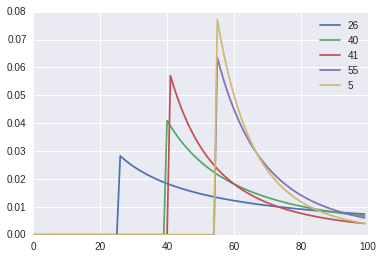

In [7]:
tank_problem = GermanTankProblem(list(range(100)))

fig, ax = plt.subplots()

observations = [26, 40, 41, 55, 5]
for observation in observations:
    tank_problem.update(observation)
    
    tank_problem.plot(ax=ax)
    print('mean {}, var {}'
          .format(tank_problem.mean(), tank_problem.var()))

ax.legend(observations)

# Bayesian Robot Perception (e02)

See the exercise sheet.

In [8]:
class BayesianPerception(Suite):
    def likelihood(self, evidence, hypo):
        _likelihood = {'is_open':   {'sense_closed': .4, 'sense_open': .6},
                       'is_closed': {'sense_closed': .8, 'sense_open': .2},
        }
        return _likelihood[hypo][evidence]

In [9]:
model = BayesianPerception(['is_open', 'is_closed'])
print(model)
print()

observations = ['sense_open', 'sense_closed', 'sense_open', 'sense_open', 'sense_open']
for evidence in observations:
    print('Observing {}'.format(evidence))
    model.update(evidence)
    model.print()
    print()

BayesianPerception([('is_open', 0.5), ('is_closed', 0.5)])

Observing sense_open
is_open: 0.75
is_closed: 0.25

Observing sense_closed
is_open: 0.6
is_closed: 0.4

Observing sense_open
is_open: 0.818181818182
is_closed: 0.181818181818

Observing sense_open
is_open: 0.931034482759
is_closed: 0.0689655172414

Observing sense_open
is_open: 0.975903614458
is_closed: 0.0240963855422



# Robot Localization
A simple histogram filter in a circular world.

Additionally to the likelihood function we have to implement the prediction step.

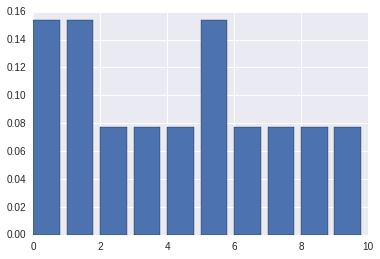

In [10]:
class HistogramFilter(Suite):
    def likelihood(self, evidence, hypo):
        map_ = [1, 1, 0, 0, 0, 1, 0, 0, 0, 0]
        likelihood_ = {
             1: {'landmark': .6, 'no_landmark': .4},
             0: {'landmark': .3, 'no_landmark': .7}
        }
        l_at_pos = map_[hypo]
        return likelihood_[l_at_pos][evidence]
    
    # make it look like predict/correct filter
    def predict(self, u):
        # motion model
        p_trans = {
            'left':  dict(left=0.8, stand=0.2, right=0.0),
            'stand': dict(left=0.0, stand=1.0, right=0.0),
            'right': dict(left=0.1, stand=0.2, right=0.7),
        }
        
        bel_ = [sum([p_trans[u]['left']  * self[(i+1) % self.n],
                     p_trans[u]['stand'] * self[i],
                     p_trans[u]['right'] * self[(i-1) % self.n]])
                for i in range(self.n)]
        
        for i in range(self.n):
            self[i] = bel_[i]
            
    def correct(self, evidence):
        """Wrapper to add the familiar `correct` function of Bayes' filters."""
        self.update(evidence)


hist_filter = HistogramFilter(range(10))
hist_filter.update('landmark')
hist_filter.plot_bar()

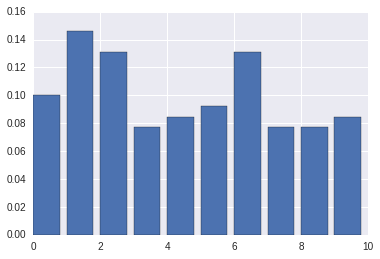

In [11]:
hist_filter.predict('right')
hist_filter.plot_bar()

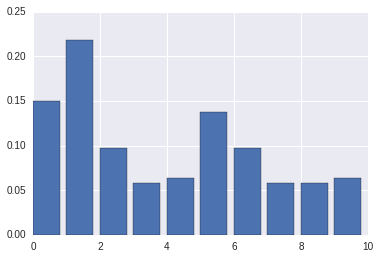

In [12]:
hist_filter.update('landmark')
hist_filter.plot_bar()

# Fine Grained Localization with Gaussian Observation

Just a quick draft to demonstrate that you can implement more complex scenarios.

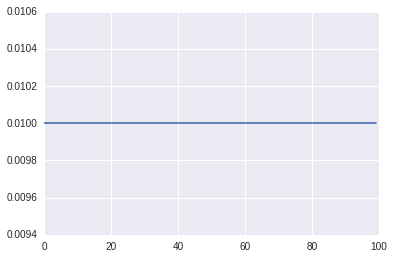

In [13]:
from functools import reduce
import operator


def mul(l):
    """mul() like sum()"""
    return reduce(operator.mul, l, 1)


dom = 100
landmarks = [5, 15, 55]
like_landmark = []
for pos in range(dom):
    like_landmark.append(
        sum(sp.stats.norm.pdf(pos, pos_of_landmark, 4) for pos_of_landmark in landmarks)
    )


class Localization(Suite): 
    def likelihood(self, evidence, hypo):
        if evidence is True:
            return like_landmark[hypo]
        else:
            raise ValueError()
    
    # make it look like predict/correct filter
    def predict(self, u):
        # motion model as before
        p_trans = {
            'left':  dict(left=0.8, stand=0.2, right=0.0),
            'stand': dict(left=0.0, stand=1.0, right=0.0),
            'right': dict(left=0.1, stand=0.2, right=0.7),
        }
        bel_ = [sum([p_trans[u]['left']  * self[(i+1) % self.n],
                     p_trans[u]['stand'] * self[i],
                     p_trans[u]['right'] * self[(i-1) % self.n]])
                for i in range(self.n)]
        for i in range(self.n):
            self[i] = bel_[i]
            
    def correct(self, landmark_seen):
        """Only call """
        self.update(landmark_seen)


localization = Localization(range(dom))

fig, ax = plt.subplots()
localization.plot(ax=ax)

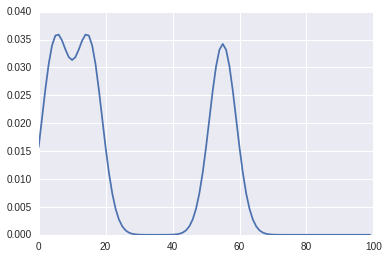

In [14]:
localization.correct(True)
localization.plot()

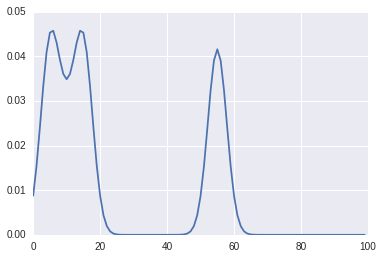

In [15]:
localization.correct(True)
localization.plot()

In [16]:
for i in range(25):
    localization.predict('right')

localization.plot(ax=ax)

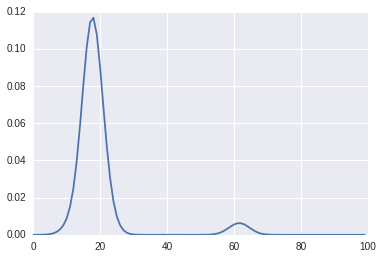

In [17]:
localization.correct(True)
localization.plot()